In [1]:
# %cd gestures/
!ls

Mediapipe_test.ipynb			    gest.zip
__pycache__				    gestures
arcface.py				    lin_comb_mar23.ckpt
asl-sign-detection-pytorch-lightning.ipynb  pizdec.ipynb
autsl-custom-try.ipynb			    prof_logs
baseline.ckpt				    requirements.txt
data					    swin_mar29.ckpt
ds.py					    swin_mar30.ckpt
ds_preprocess.ipynb			    transformer_mar24.ckpt
fit-profiler_logs.txt			    wandb


In [2]:
# pip list

In [3]:
%%time
from tqdm.notebook import tqdm
import torch
from torch import nn, optim
from torch.nn import functional as F
from matplotlib import pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torch.utils.data import DataLoader, random_split, Dataset
import pytorch_lightning as pl
from torchvision.models import regnet_y_400mf, RegNet_Y_400MF_Weights, efficientnet_b1, EfficientNet_B1_Weights
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from arcface import ArcFaceLoss
import graphviz
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy, MulticlassConfusionMatrix
import torchvision
import json
import pandas as pd
from torchmetrics import MetricCollection
import os
import seaborn as sns
import torchvision.transforms.v2 as tf
from ds import VideoFrameDataset, ImglistToTensor
from torchvision.models.video.swin_transformer import swin3d_b, Swin3D_B_Weights


from pytorch_lightning.callbacks import LearningRateMonitor
torch.set_float32_matmul_precision("medium")

from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

CPU times: user 5.33 s, sys: 1.24 s, total: 6.56 s
Wall time: 49.7 s


In [4]:
# pip freeze > requirements.txt

In [5]:
# import warnings
# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')

In [6]:
# torch.cuda.empty_cache()
print(torch.cuda.list_gpu_processes())

GPU:0
no processes are running


### Dataset

In [7]:
MODEL_INPUT_SIZE = 200

class NpToTensor(torch.nn.Module):
    @staticmethod
    def forward(img_list):
        return (torch.tensor(img_list.transpose(0, 3, 1, 2)).float() / 255)

frame_transforms = {
    'train': tf.Compose([
        # ImglistToTensor(),
        NpToTensor(),
        # tf.RandomApply([tf.ColorJitter(0.3, 0.3, 0.3, 0.3)], p=0.9),
        # tf.RandomApply([tf.RandomAffine(0, None, (0.95, 1.05), (-10, 10, -10, 10), tf.InterpolationMode.BILINEAR)], p=0.9),
        # tf.RandomCrop((MODEL_INPUT_SIZE, MODEL_INPUT_SIZE)),
        # tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'val': tf.Compose([
        # ImglistToTensor(),
        NpToTensor(),
        # tf.RandomCrop((MODEL_INPUT_SIZE, MODEL_INPUT_SIZE)),
        # tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])}

In [8]:
ds_path = 'data/autsl_frames'
train_ds = torchvision.datasets.DatasetFolder(
                    root=f'data/autsl_np8/train',
                    loader=np.load,
                    transform=frame_transforms['train'],
                    extensions=('.npy'), )
# VideoFrameDataset(
#     'data/autsl_frames/train',
#     'data/autsl_frames/train/annotations.txt',
#     8,
#     1,
#     imagefile_template= 'img_{:04d}.jpg',
#     transform=frame_transforms['train']
# )

val_ds = torchvision.datasets.DatasetFolder(
                    root=f'data/autsl_np8/val',
                    loader=np.load,
                    transform=frame_transforms['val'],
                    extensions=('.npy'), )
# VideoFrameDataset(
#     'data/autsl_frames/val',
#     'data/autsl_frames/val/annotations.txt',
#     8,
#     1,
#     imagefile_template= 'img_{:04d}.jpg',
#     transform=frame_transforms['val']
# )

In [9]:
len(train_ds), len(val_ds)

(28132, 4418)

In [10]:
vid = train_ds[130][0]
vid.shape

torch.Size([8, 3, 280, 280])

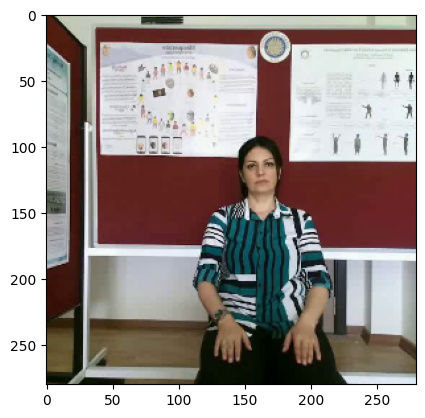

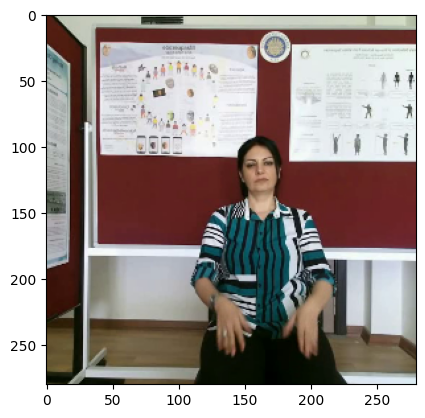

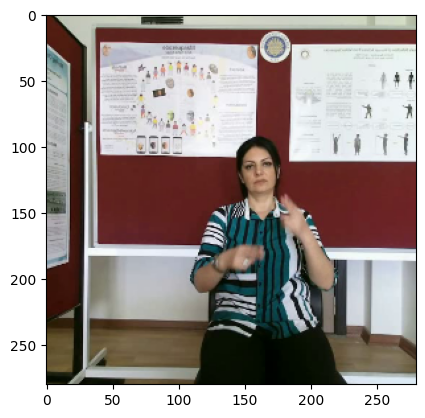

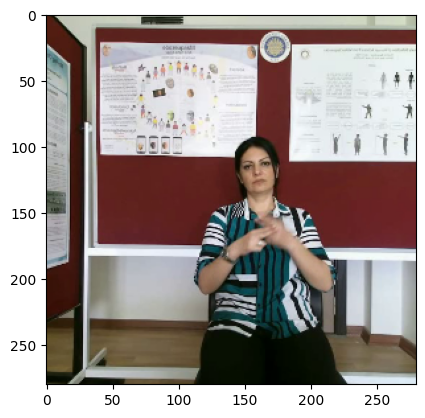

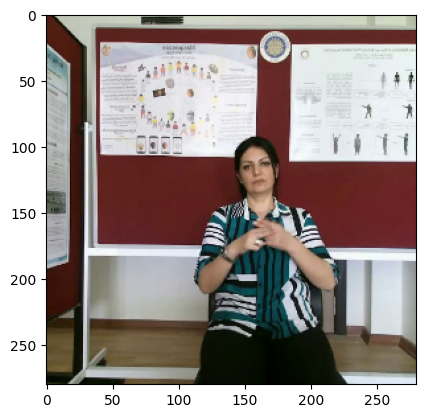

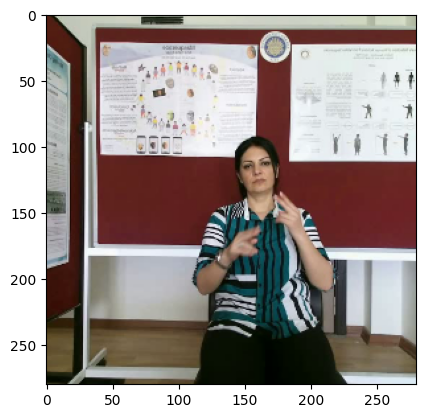

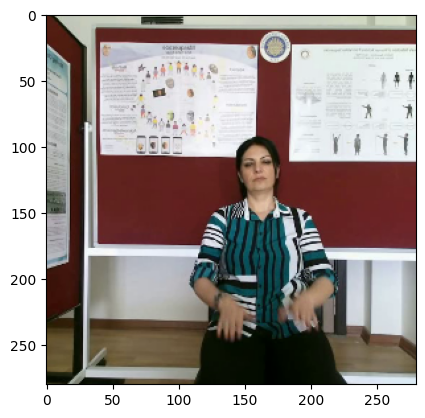

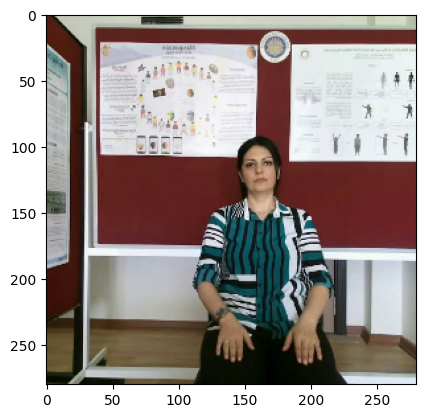

In [11]:
for frame in vid:
    frame = frame.cpu().numpy().transpose(1,2,0)
    frame -= frame.min()
    frame /= frame.max()
    plt.imshow(frame)
    plt.show()

In [12]:
def batch_as_list_collate(batch_samples):
    return batch_samples

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=8, drop_last=True ,pin_memory=False)#, collate_fn=batch_as_list_collate)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=8, pin_memory=False)#, collate_fn=batch_as_list_collate)

### Model

In [13]:
EMB_SIZE = 256
cnn_model_name = 'effnetb1'

In [14]:
class FrameEncoder(nn.Module):
    def __init__(self, emb_dim, base_model_name=None, weights=None):
        super().__init__()
        self.emb_dim = emb_dim
        if base_model_name is not None:
            self.model = torchvision.models.get_model(base_model_name, weights=weights)
    
    def forward(self, X):
        return self.model(X)

    
class TemporalEncoder(nn.Module):
    def __init__(self, emb_dim, seq_len=8):
        super().__init__()
        self.out_dim = emb_dim
        self.seq_len = seq_len
        self.model = None

    def forward(self, X):
        return self.model(X)
    
    
class EfficientNetEncoder(FrameEncoder):
    def __init__(self, emb_dim, base_model_name, weights: str = 'DEFAULT'):
        super().__init__(emb_dim, base_model_name, weights)
        self.model.classifier = nn.Sequential(
                nn.Dropout(p=0.2, inplace=True),
                nn.Linear(in_features=1280, out_features=self.emb_dim, bias=True)
        )

        
class AverageEncoder(TemporalEncoder):
    def __init__(self, emb_dim, seq_len):
        super().__init__(emb_dim, seq_len)

    def forward(self, X):
        return X.mean(dim=-2)
    

class LinearCombination(TemporalEncoder):
    def __init__(self, emb_dim, seq_len=8):
        super().__init__(emb_dim, seq_len)
        self.alpha = nn.Parameter(torch.rand(self.seq_len))
        
    def forward(self, X):
        # alpha = F.normalize(self.alpha, p=1, dim=0)
        alpha = F.softmax(self.alpha, dim=-1)
        out = X.transpose(-1, -2) @ alpha
        return out
    

class TransformerEncoder(TemporalEncoder):
    def __init__(self, emb_dim, seq_len=8):
        super().__init__(emb_dim, seq_len)
        layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(layer, num_layers=2)
        
    def forward(self, X):
        out = self.transformer(X)
        out = torch.mean(out, dim=-2)
        return out


class VideoEncoder(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.frame_enc = EfficientNetEncoder(emb_dim, 'efficientnet_b1')
        # self.temporal_enc = AverageEncoder(emb_dim)
        # self.temporal_enc = LinearCombination(emb_dim)
        self.temporal_enc = TransformerEncoder(emb_dim)

    def forward(self, X):
        init_shape = X.shape
        frame_embs = self.frame_enc(X.flatten(0, 1)).reshape(*init_shape[:2], -1)
        video_emb = self.temporal_enc(frame_embs)
        return video_emb

class VideoClassifier(nn.Module):
    def __init__(self, emb_dim, num_classes):
        super().__init__()
        self.video_encoder = VideoEncoder(emb_dim)
        self.fc = nn.Linear(emb_dim, num_classes, bias=True)

    def forward(self, X):
        emb = self.video_encoder(X)
        out = self.fc(emb)
        return out
    
class SwinTransformer(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = swin3d_b(weights=Swin3D_B_Weights.DEFAULT)
        self.model.head = nn.Linear(in_features=1024, out_features=num_classes, bias=True)
    
    def forward(self, X):
        return self.model(X)

In [15]:
class LITModule(pl.LightningModule):
    def __init__(
        self,
        emb_dim: float,
        drop_rate: float,
        eta_min: float,
        learning_rate: float,
        loss: str,
        num_classes: int,
        optimizer: str,
        scheduler: str,
        weight_decay: float,
        pretrained_path: str = None,
        pretrained_frame_encoder_path: str = None
    ):
        super().__init__()

        self.save_hyperparameters()

        self.model = self._init_model(pretrained_path, pretrained_frame_encoder_path)

        self.loss_fn = self._init_loss_fn()

        self.metrics = self._init_metrics()
        
        self.transforms = self._init_transforms()

    def _init_model(self, pretrained_path=None, pretrained_frame_encoder_path=None):
        if pretrained_path is not None:
            return torch.load(pretrained_path)
        
        # model = VideoClassifier(
        #         emb_dim=self.hparams.emb_dim,
        #         num_classes=self.hparams.num_classes,
        #     )
        
        model = SwinTransformer(
            num_classes=self.hparams.num_classes)
        
        if pretrained_frame_encoder_path is not None:
            model.frame_enc = torch.load(pretrained_frame_encoder_path)
            
        return model
            

    def _init_loss_fn(self):
        if self.hparams.loss == "CELoss":
            return torch.nn.CrossEntropyLoss()
        else:
            raise ValueError(f"{self.hparams.loss} is not a valid loss function")

    def _init_metrics(self):
        metrics = {
                   # 'rocauc': MulticlassAUROC(self.hparams.num_classes),
                   'acc@1' : MulticlassAccuracy(self.hparams.num_classes, top_k=1),
                   'acc@5' : MulticlassAccuracy(self.hparams.num_classes, top_k=5),
                   'acc@10': MulticlassAccuracy(self.hparams.num_classes, top_k=10),
        }
        metric_collection = MetricCollection(metrics)

        return torch.nn.ModuleDict(
            {
                "train_metrics": metric_collection.clone(prefix="train_"),
                "val_metrics": metric_collection.clone(prefix="val_"),
            }
        )

    def configure_optimizers(self):
        optimizer = self._init_optimizer()

        scheduler = self._init_scheduler(optimizer)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
            },
        }

    def _init_optimizer(self):
        if self.hparams.optimizer == 'AdamW':
            optimizer = torch.optim.AdamW(
                params=self.parameters(),
                lr=self.hparams.learning_rate)
        else:
            raise ValueError(f"Unknown optimizer: {self.hparams.optimizer}")
        return optimizer

    def _init_scheduler(self, optimizer):
        if self.hparams.scheduler == "CosineAnnealingLR":
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=self.trainer.max_epochs,
                eta_min=self.hparams.eta_min,
            )
        elif self.hparams.scheduler == "StepLR":
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer,
                step_size=self.trainer.max_epochs // 5,
                gamma=0.95,
            )
        elif self.hparams.scheduler == "OneCycleLR":
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=self.hparams.learning_rate,
                total_steps=self.trainer.estimated_stepping_batches,
                pct_start=2.5 / self.trainer.max_epochs,
                final_div_factor=50,
                div_factor=1e3
            )
        else:
            raise ValueError(f"Unknown scheduler: {self.hparams.scheduler}")
        return scheduler
    
    def _init_transforms(self):
        swin_transform = Swin3D_B_Weights.DEFAULT.transforms()
        transforms = {
            'train': nn.Sequential(
                tf.ElasticTransform(),
                tf.RandomPhotometricDistort(p=0.9),
                tf.RandomPerspective(distortion_scale=0.35, p=0.7),
                swin_transform),
            'val': swin_transform
        }
        
        # transforms = {
        #     'train': transform,
        #     'val': transform
        # }
            
        return transforms

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch):
        return self._shared_step(batch, "train")

    def on_train_epoch_end(self):
        self._log_on_epoch_end('train')

    def validation_step(self, batch, batch_idx):
        self._shared_step(batch, "val")

    def on_validation_epoch_end(self):
        self._log_on_epoch_end('val')

    def predict_step(self, batch, batch_idx):
        _, labels, logits = self._forward_pass(batch, stage=None)
        preds = F.softmax(logits, dim=-1)
        return preds, labels

    def _shared_step(self, batch, stage):
        x, y, y_pred = self._forward_pass(batch, stage)

        loss = self.loss_fn(y_pred, y)

        self.metrics[f"{stage}_metrics"](y_pred, y)

        self._log_on_step(stage, loss, batch_size=len(x))

        return loss

    def _forward_pass(self, batch, stage):
        x, y = batch
        y = y.view(-1)
        # batch_size, seq_len = x.shape[:2]
        # x = self.transforms[stage](x.flatten(0, 1))
        # x = x.reshape(batch_size, seq_len, *x.shape[1:])
        x = self.transforms[stage](x)
        y_pred = self(x)

        return x, y, y_pred

    def _log_on_step(self, stage, loss, batch_size):
        self.log(f"{stage}_loss", loss, batch_size=batch_size)

    def _log_on_epoch_end(self, stage):
        self.log_dict(self.metrics[f"{stage}_metrics"])

In [16]:
module = LITModule(
    drop_rate = 0.4,
    eta_min = 1e-6,
    learning_rate= 7e-5,
    loss = "CELoss",
    num_classes=226,
    emb_dim = EMB_SIZE,
    optimizer = "AdamW",
    scheduler = "OneCycleLR",
    weight_decay= 1e-6,
    pretrained_path='swin_mar30.ckpt',
    # pretrained_frame_encoder_path='frame_enc.ckpt',
)

In [17]:
import wandb
WANDB_APIKEY = 'a5bd0bef55f8b72f59ac12d24f1623ad19eeb67b'
wandb.login(key=WANDB_APIKEY)
logger = WandbLogger(project='gestures')

wandb: Currently logged in as: eldervald (valoebi). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Train 

In [18]:
# logger = TensorBoardLogger("../tf_logs/", name=f"5mf-img_embs-{cnn_model_name}-{EMB_SIZE}-{num_classes}cls+gradcam")
lr_monitor = LearningRateMonitor(logging_interval='step')
from pytorch_lightning.profilers import AdvancedProfiler, SimpleProfiler
# profiler = AdvancedProfiler(dirpath='./', filename='adv_profiler_logs')
trainer = pl.Trainer(accelerator='gpu',
                     devices=1,
                     logger=logger,
                     accumulate_grad_batches=4,
                     # auto_lr_find=True,
                     log_every_n_steps=1,
                     max_epochs=10,
                     # max_steps=60,
                     val_check_interval=1.0,
                     callbacks=[lr_monitor],
                     profiler=SimpleProfiler(dirpath='./', filename='profiler_logs'),
                     # profiler=profiler,
                     # track_grad_norm=2,
                     # gradient_clip_val=10,
                     # gradient_clip_algorithm="norm",
                    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [19]:
# trainer.tune(model, train_loader, val_loader, lr_find_kwargs={"num_training":200})

In [20]:
trainer.fit(module, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name    | Type             | Params
---------------------------------------------
0 | model   | SwinTransformer  | 87.9 M
1 | loss_fn | CrossEntropyLoss | 0     
2 | metrics | ModuleDict       | 0     
---------------------------------------------
87.9 M    Trainable params
0         Non-trainable params
87.9 M    Total params
351.483   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:01, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [30]:
torch.save(module.model, f'swin_mar30.ckpt')

In [22]:
# torch.save(module.model.video_encoder.frame_enc, f'frame_enc.ckpt')

In [23]:
# F.softmax(module.model.video_encoder.temporal_enc.alpha)

In [24]:
module.model

SwinTransformer(
  (model): SwinTransformer3d(
    (patch_embed): PatchEmbed3d(
      (proj): Conv3d(3, 128, kernel_size=(2, 4, 4), stride=(2, 4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (features): Sequential(
      (0): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): ShiftedWindowAttention3d(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (proj): Linear(in_features=128, out_features=128, bias=True)
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=512, out_features

In [25]:
x = next(iter(train_loader))[0]

In [26]:
trans = tf.Compose([
        tf.RandomPhotometricDistort(p=0.9),
        tf.ElasticTransform(),
        tf.RandomPerspective(distortion_scale=0.35, p=0.7),
        Swin3D_B_Weights.DEFAULT.transforms()
])

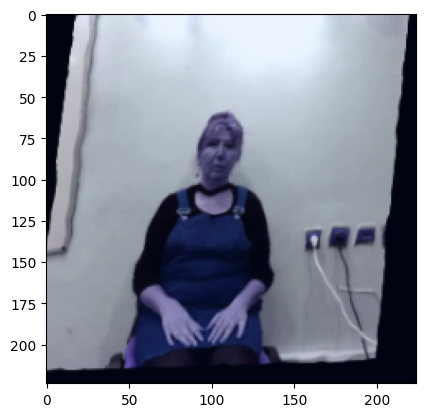

In [27]:
res = trans(x)
img = res[0,:, 0]
img -= img.min()
img /= img.max()
plt.imshow(img.permute(1, 2, 0))

In [28]:
res.shape

torch.Size([16, 3, 8, 224, 224])

In [29]:
trans

Compose(
      RandomPhotometricDistort(brightness=(0.875, 1.125), contrast=(0.5, 1.5), hue=(-0.05, 0.05), saturation=(0.5, 1.5), p=0.9)
      ElasticTransform(alpha=[50.0, 50.0], sigma=[5.0, 5.0], interpolation=InterpolationMode.BILINEAR, fill=0)
      RandomPerspective(p=0.7, distortion_scale=0.35, interpolation=InterpolationMode.BILINEAR, fill=0)
      VideoClassification(
      crop_size=[224, 224]
      resize_size=[256]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BILINEAR
  )
)